# Prophet Forecast - Fixed Window Solution

* I'm going to use Facebook Prophet to do the forecasting, and see how it goes.
* Use all the training data first, finxed window solution.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# the logger here is to remove the warnings about plotly
import logging
logger = logging.getLogger('fbprophet.plot')
logger.setLevel(logging.CRITICAL)
from fbprophet import Prophet

In [158]:
sample_train_df1 = pd.read_pickle('sample_train_df1.pkl')
sample_test_df1 = pd.read_pickle('sample_test_df1.pkl')
print(sample_train_df1.shape, sample_test_df1.shape)

sample_train_df2 = pd.read_pickle('sample_train_df2.pkl')
sample_test_df2 = pd.read_pickle('sample_test_df2.pkl')
print(sample_train_df2.shape, sample_test_df2.shape)

sample_train_df1.head()

(100, 2) (14, 2)
(100, 2) (10, 2)


,purchase_amount,client_count
purchase_date,,
2019-02-11,58743.49,470
2019-02-12,73984.82,686
2019-02-13,95749.55,876
2019-02-14,118723.62,1095
2019-02-15,152350.76,1379


In [159]:
train1_col = sample_train_df1['client_count']
train2_col = sample_train_df2['client_count']
test1_col = sample_test_df1['client_count']
test2_col = sample_test_df2['client_count']

# Generate logged moving average for both time series sequences
ts_log_train1 = np.log(train1_col)
ts_moving_avg_train1 = ts_log_train1.rolling(window=4,center=False).mean()
ts_log_test1 = np.log(test1_col)
ts_moving_avg_test1 = ts_log_test1.rolling(window=4,center=False).mean()

ts_log_train2 = np.log(train2_col)
ts_moving_avg_train2 = ts_log_train2.rolling(window=4,center=False).mean()
ts_log_test2 = np.log(test2_col)
ts_moving_avg_test2 = ts_log_test2.rolling(window=4,center=False).mean()

print(ts_moving_avg_train1.shape, ts_moving_avg_train2.shape, ts_moving_avg_test1.shape, ts_moving_avg_test2.shape)
ts_moving_avg_test1.head()

(100,) (100,) (14,) (10,)


purchase_date
2019-05-22         NaN
2019-05-23         NaN
2019-05-24         NaN
2019-05-25    3.748604
2019-05-26    3.671921
Name: client_count, dtype: float64

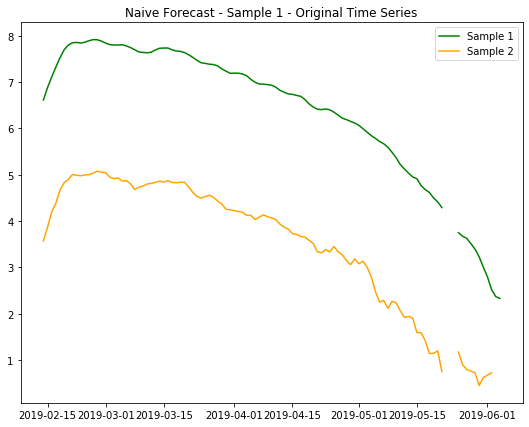

In [4]:
plt.figure(figsize=(9,7))
plt.plot(ts_moving_avg_train1.index, ts_moving_avg_train1, label='Sample 1', color='green')
plt.plot(ts_moving_avg_test1.index, ts_moving_avg_test1, color='green')
plt.plot(ts_moving_avg_train2.index, ts_moving_avg_train2, label='Sample 2', color='orange')
plt.plot(ts_moving_avg_test2.index, ts_moving_avg_test2, color='orange')
plt.legend(loc='best')
plt.title("Naive Forecast - Sample 1 - Original Time Series")
plt.show()

## Logged Time Series - Fixed Windows Solution

### Sample 1

In [56]:
train = pd.DataFrame(ts_log_train1.copy())
train['ds'] = train.index
train['y'] = ts_log_train1.values
train.drop(['client_count'], inplace=True, axis=1)
train.head()

,ds,y
purchase_date,,
2019-02-11,2019-02-11,6.152733
2019-02-12,2019-02-12,6.530878
2019-02-13,2019-02-13,6.775366
2019-02-14,2019-02-14,6.998510
2019-02-15,2019-02-15,7.229114


In [57]:
test = pd.DataFrame(ts_log_test1.copy())
test['ds'] = test.index
test['y'] = ts_log_test1.values
test.drop(['client_count'], inplace=True, axis=1)
test.head()

,ds,y
purchase_date,,
2019-05-22,2019-05-22,3.970292
2019-05-23,2019-05-23,3.713572
2019-05-24,2019-05-24,3.784190
2019-05-25,2019-05-25,3.526361
2019-05-26,2019-05-26,3.663562


In [58]:
import warnings
warnings.filterwarnings("ignore")

model_log1 = Prophet(daily_seasonality = True, yearly_seasonality=False, seasonality_mode = 'multiplicative',
                seasonality_prior_scale=0.1)  # seasonality_prior_scale decides the influence of seasonality
model_log1.fit(train)

In [59]:
periods = len(test.index)
print(periods)
future = model_log1.make_future_dataframe(periods=periods)
forecast = model_log1.predict(future)

forecast.head()

14


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-02-11,3.107089,6.224997,6.366507,3.107089,3.107089,1.01744,1.01744,1.01744,1.026730,1.026730,1.026730,0.009290,0.009290,0.009290,0.0,0.0,0.0,6.297232
1,2019-02-12,3.223908,6.464918,6.606839,3.223908,3.223908,1.01744,1.01744,1.01744,1.028246,1.028246,1.028246,0.010806,0.010806,0.010806,0.0,0.0,0.0,6.538879
2,2019-02-13,3.340727,6.690146,6.834030,3.340727,3.340727,1.01744,1.01744,1.01744,1.024252,1.024252,1.024252,0.006812,0.006812,0.006812,0.0,0.0,0.0,6.762472
3,2019-02-14,3.457546,6.878224,7.016924,3.457546,3.457546,1.01744,1.01744,1.01744,1.008714,1.008714,1.008714,-0.008726,-0.008726,-0.008726,0.0,0.0,0.0,6.945219
4,2019-02-15,3.568534,7.074940,7.221000,3.568534,3.568534,1.01744,1.01744,1.01744,1.003476,1.003476,1.003476,-0.013964,-0.013964,-0.013964,0.0,0.0,0.0,7.149474


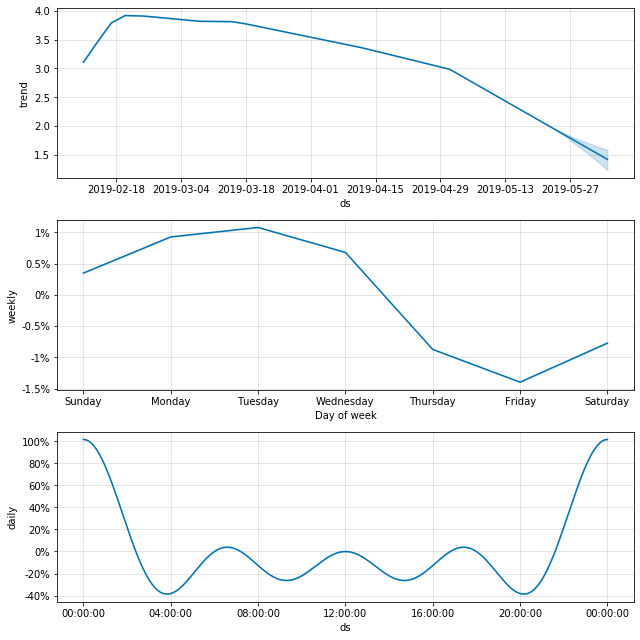

In [60]:
fig1 = model_log1.plot_components(forecast)

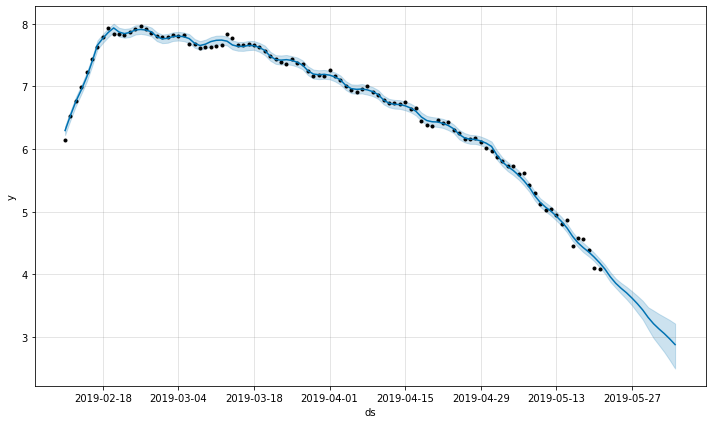

In [61]:
firg2 = model_log1.plot(forecast)

In [62]:
y_pred = forecast.loc[(forecast['ds']>=min(test.index)) & (forecast['ds']<=max(test.index))]['yhat']
y_pred.index = test.index
print(y_pred.shape)

y_pred.head()

(14,)


purchase_date
2019-05-22    4.086163
2019-05-23    3.962313
2019-05-24    3.859739
2019-05-25    3.779239
2019-05-26    3.707289
Name: yhat, dtype: float64

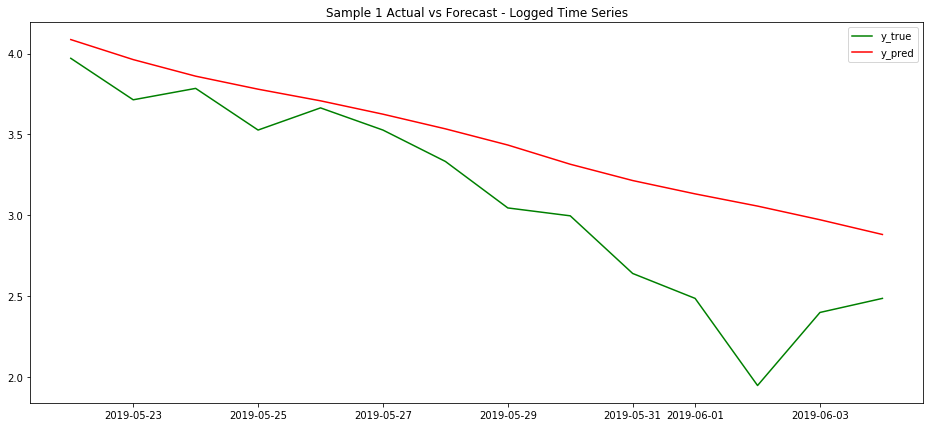

0.45643689349167504

In [63]:
plt.figure(figsize=(16,7))
plt.plot(ts_log_test1.index, ts_log_test1, label='y_true', color='green')
plt.plot(y_pred.index, y_pred, label = 'y_pred', color='red')
plt.legend(loc='best')
plt.title("Sample 1 Actual vs Forecast - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(ts_log_test1, y_pred))
rmse

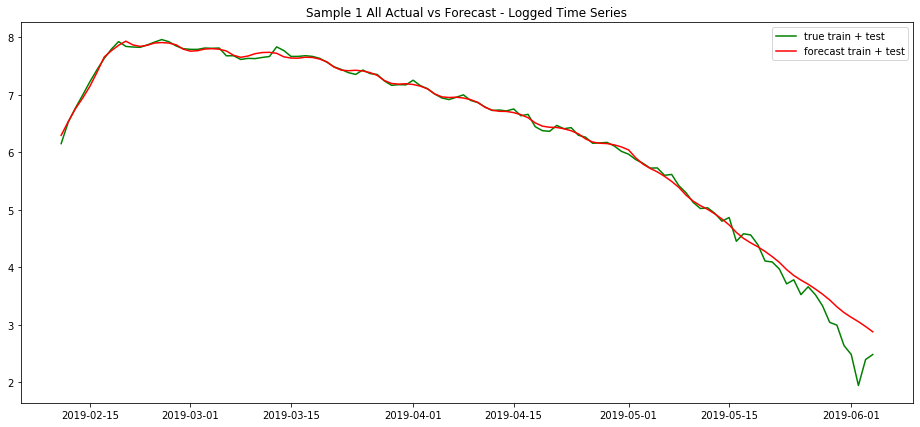

0.16813077034765836

In [64]:
y_all = forecast['yhat']
y_all.index = forecast['ds']

ts_log1 = ts_log_train1.copy()
ts_log1 = ts_log1.append(ts_log_test1)

plt.figure(figsize=(16,7))
plt.plot(ts_log1.index, ts_log1, label='true train + test', color='green')
plt.plot(y_all.index, y_all, label = 'forecast train + test', color='red')
plt.legend(loc='best')
plt.title("Sample 1 All Actual vs Forecast - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(ts_log1, y_all))
rmse

In [65]:
true_pred_df = forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
true_pred_df['y_true'] = ts_log1.values
print(true_pred_df.shape)

true_pred_df.head()

(114, 5)


,ds,yhat_lower,yhat_upper,yhat,y_true
0,2019-02-11,6.224997,6.366507,6.297232,6.152733
1,2019-02-12,6.464918,6.606839,6.538879,6.530878
2,2019-02-13,6.690146,6.834030,6.762472,6.775366
3,2019-02-14,6.878224,7.016924,6.945219,6.998510
4,2019-02-15,7.074940,7.221000,7.149474,7.229114


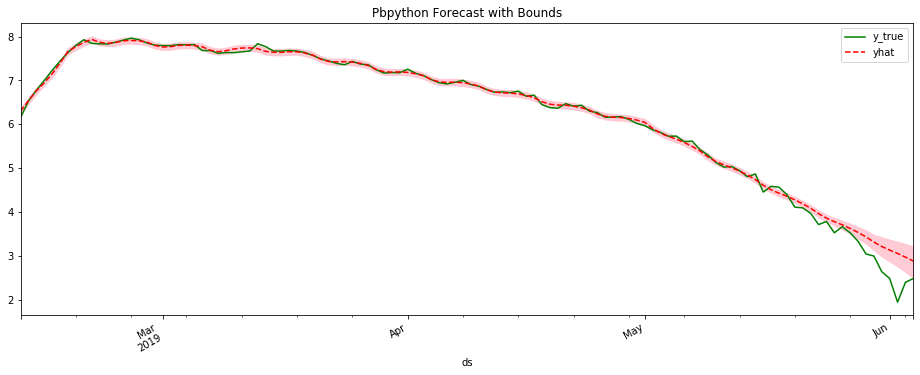

In [66]:
fig, ax = plt.subplots(figsize=(16, 7))
true_pred_df.plot(kind='line', x='ds', y=['y_true', 'yhat'], ax=ax, style=['-','--'], color=['green', 'red'])
ax.fill_between(true_pred_df['ds'].values, true_pred_df['yhat_lower'], true_pred_df['yhat_upper'], alpha=0.8, color='pink')
ax.set(title='Pbpython Forecast with Bounds')
fig.autofmt_xdate(bottom=0.3, rotation=30, ha='right')

#### Notes

* It will forecast not only the testing data, but the whole time series. That's why I'm ploting both train and test data here.
  * Maybe Prophet is better to beused for moving window solution, since it might be building a function for the whole time series.
* For logged sample 1, performance order:
  * moving window without param tuning > Prophet > moving window with param tuning

### Sample 2

In [173]:
train = pd.DataFrame(ts_log_train2.copy())
train['ds'] = train.index
train['y'] = ts_log_train2.values
train.drop(['client_count'], inplace=True, axis=1)
train.head()

,ds,y
purchase_date,,
2019-02-11,2019-02-11,3.135494
2019-02-12,2019-02-12,3.433987
2019-02-13,2019-02-13,3.850148
2019-02-14,2019-02-14,3.871201
2019-02-15,2019-02-15,4.317488


In [174]:
test = pd.DataFrame(ts_log_test2.copy())
test['ds'] = test.index
test['y'] = ts_log_test2.values
test.drop(['client_count'], inplace=True, axis=1)
test.head()

,ds,y
purchase_date,,
2019-05-22,2019-05-22,1.098612
2019-05-23,2019-05-23,1.098612
2019-05-24,2019-05-24,1.386294
2019-05-25,2019-05-25,1.098612
2019-05-26,2019-05-26,0.000000


In [175]:
import warnings
warnings.filterwarnings("ignore")

model_log2 = Prophet(daily_seasonality = True, yearly_seasonality=False, seasonality_mode = 'multiplicative',
                seasonality_prior_scale=0.1)  # seasonality_prior_scale decides the influence of seasonality
model_log2.fit(train)

In [176]:
periods = len(test.index)
print(periods)
future = model_log2.make_future_dataframe(periods=periods)
forecast = model_log2.predict(future)

forecast.head()

10


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-02-11,2.566875,3.947945,4.786928,2.566875,2.566875,0.67522,0.67522,0.67522,0.695565,0.695565,0.695565,0.020345,0.020345,0.020345,0.0,0.0,0.0,4.352303
1,2019-02-12,2.587126,3.966935,4.822618,2.587126,2.587126,0.67522,0.67522,0.67522,0.691065,0.691065,0.691065,0.015845,0.015845,0.015845,0.0,0.0,0.0,4.374999
2,2019-02-13,2.607377,3.921543,4.757976,2.607377,2.607377,0.67522,0.67522,0.67522,0.663794,0.663794,0.663794,-0.011425,-0.011425,-0.011425,0.0,0.0,0.0,4.338140
3,2019-02-14,2.627628,4.037183,4.830328,2.627628,2.627628,0.67522,0.67522,0.67522,0.678520,0.678520,0.678520,0.003300,0.003300,0.003300,0.0,0.0,0.0,4.410527
4,2019-02-15,2.647879,3.962338,4.810663,2.647879,2.647879,0.67522,0.67522,0.67522,0.664660,0.664660,0.664660,-0.010560,-0.010560,-0.010560,0.0,0.0,0.0,4.407818


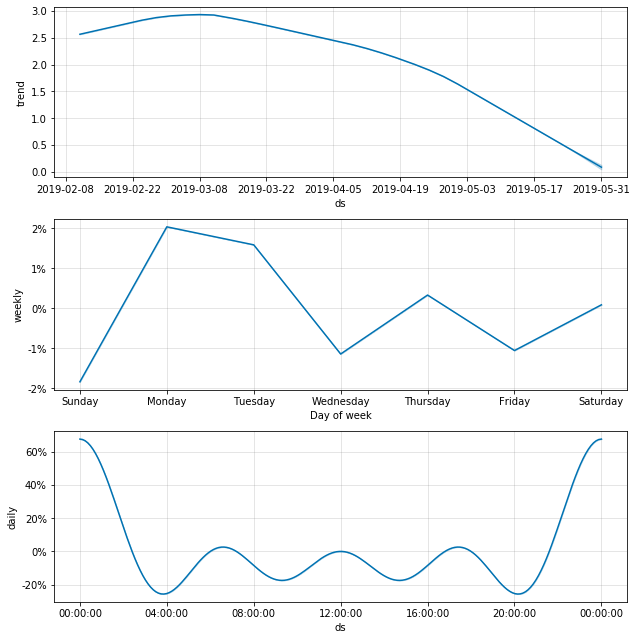

In [177]:
fig1 = model_log2.plot_components(forecast)

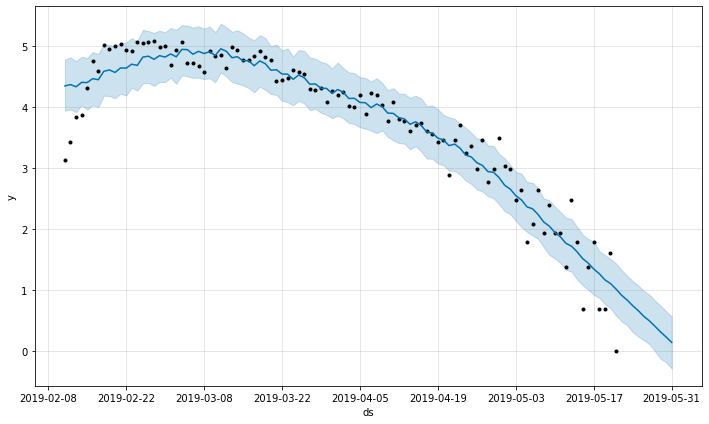

In [178]:
firg2 = model_log2.plot(forecast)

(10,)


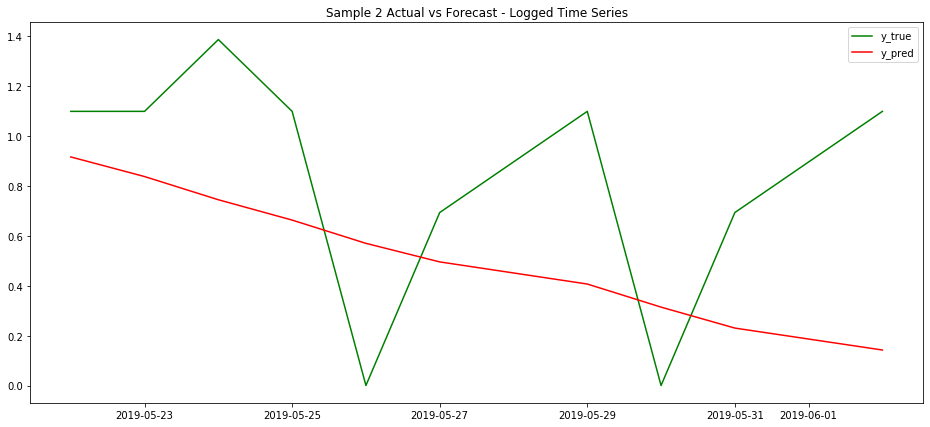

0.5266463807121111

In [179]:
y_pred = forecast.loc[(forecast['ds']>=min(test.index)) & (forecast['ds']<=max(test.index))]['yhat']
y_pred.index = test.index
print(y_pred.shape)

plt.figure(figsize=(16,7))
plt.plot(ts_log_test2.index, ts_log_test2, label='y_true', color='green')
plt.plot(y_pred.index, y_pred, label = 'y_pred', color='red')
plt.legend(loc='best')
plt.title("Sample 2 Actual vs Forecast - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(ts_log_test2, y_pred))
rmse

(110, 5)


0.3482288976041273

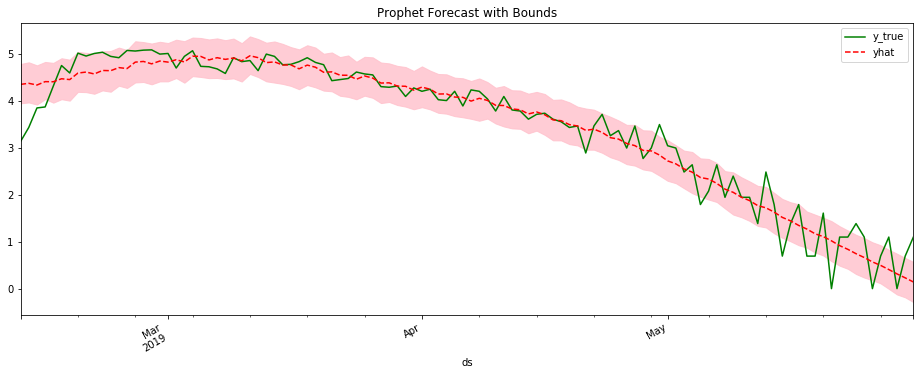

In [180]:
ts_log2 = ts_log_train2.copy()
ts_log2 = ts_log2.append(ts_log_test2)

true_pred_df = forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
true_pred_df['y_true'] = ts_log2.values
print(true_pred_df.shape)

fig, ax = plt.subplots(figsize=(16, 7))
true_pred_df.plot(kind='line', x='ds', y=['y_true', 'yhat'], ax=ax, style=['-','--'], color=['green', 'red'])
ax.fill_between(true_pred_df['ds'].values, true_pred_df['yhat_lower'], true_pred_df['yhat_upper'], alpha=0.8, color='pink')
ax.set(title='Prophet Forecast with Bounds')
fig.autofmt_xdate(bottom=0.3, rotation=30, ha='right')

rmse = sqrt(mean_squared_error(ts_log2, forecast['yhat'].values))
rmse

#### Note

* For logged Sample 2, the performance order is:
  * moving window with param tuning > prophet > moving window without param tuning
  * Prophet is only a little bit better than moving window without param tuning solution.

## Logged Moving Average

### Sample 1

In [109]:
train = pd.DataFrame(ts_moving_avg_train1.copy())
train['ds'] = train.index
train['y'] = ts_moving_avg_train1.values
train.drop(['client_count'], inplace=True, axis=1)
train.head()

,ds,y
purchase_date,,
2019-02-11,2019-02-11,NaN
2019-02-12,2019-02-12,NaN
2019-02-13,2019-02-13,NaN
2019-02-14,2019-02-14,6.614372
2019-02-15,2019-02-15,6.883467


In [110]:
test = pd.DataFrame(ts_moving_avg_test1.copy())
test['ds'] = test.index
test['y'] = ts_moving_avg_test1.values
test.drop(['client_count'], inplace=True, axis=1)
test.head()

,ds,y
purchase_date,,
2019-05-22,2019-05-22,NaN
2019-05-23,2019-05-23,NaN
2019-05-24,2019-05-24,NaN
2019-05-25,2019-05-25,3.748604
2019-05-26,2019-05-26,3.671921


In [111]:
import warnings
warnings.filterwarnings("ignore")

model_ma1 = Prophet(daily_seasonality = True, yearly_seasonality=False, 
                    seasonality_mode = 'multiplicative',
                seasonality_prior_scale=0.1)  # seasonality_prior_scale decides the influence of seasonality
model_ma1.fit(train)

periods = len(test.index)
print(periods)
future = model_ma1.make_future_dataframe(periods=periods)
forecast = model_ma1.predict(future)
print(forecast.shape)

forecast.head()

14
(114, 19)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-02-11,2.900128,5.858683,5.918596,2.900128,2.900128,1.032721,1.032721,1.032721,1.030790,1.030790,1.030790,-0.001931,-0.001931,-0.001931,0.0,0.0,0.0,5.889551
1,2019-02-12,3.020761,6.121436,6.183133,3.020761,3.020761,1.032721,1.032721,1.032721,1.036515,1.036515,1.036515,0.003794,0.003794,0.003794,0.0,0.0,0.0,6.151825
2,2019-02-13,3.141394,6.377435,6.440735,3.141394,3.141394,1.032721,1.032721,1.032721,1.040743,1.040743,1.040743,0.008022,0.008022,0.008022,0.0,0.0,0.0,6.410777
3,2019-02-14,3.262027,6.618267,6.677803,3.262027,3.262027,1.032721,1.032721,1.032721,1.038055,1.038055,1.038055,0.005334,0.005334,0.005334,0.0,0.0,0.0,6.648191
4,2019-02-15,3.382660,6.842356,6.902319,3.382660,3.382660,1.032721,1.032721,1.032721,1.031814,1.031814,1.031814,-0.000908,-0.000908,-0.000908,0.0,0.0,0.0,6.872935


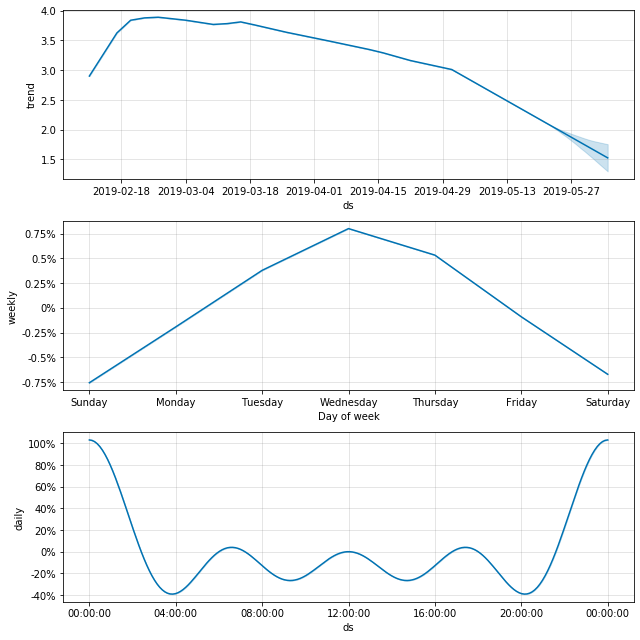

In [112]:
fig1 = model_ma1.plot_components(forecast)

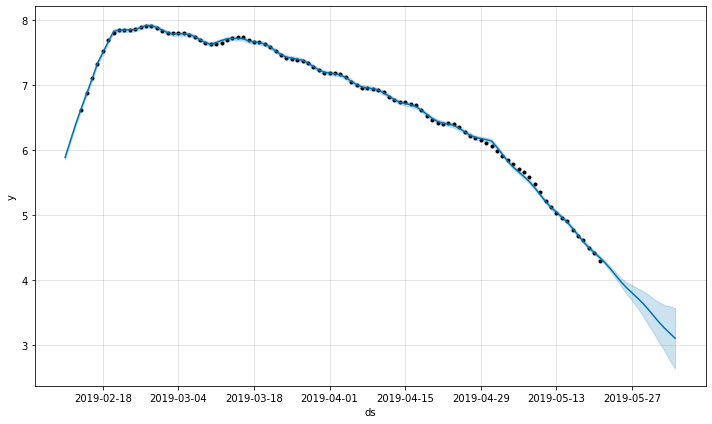

In [113]:
fig2 = model_ma1.plot(forecast)

(11,)


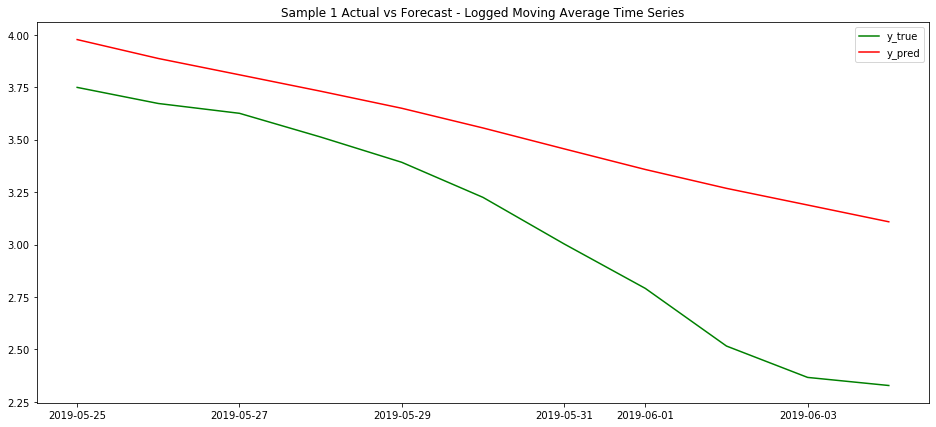

0.49799693883836205

In [118]:
ts_moving_avg_test1 = ts_moving_avg_test1.dropna()

y_pred = forecast.loc[(forecast['ds']>=min(ts_moving_avg_test1.index)) & (forecast['ds']<=max(ts_moving_avg_test1.index))]['yhat']
y_pred.index = ts_moving_avg_test1.index
print(y_pred.shape)

plt.figure(figsize=(16,7))
plt.plot(ts_moving_avg_test1.index, ts_moving_avg_test1, label='y_true', color='green')
plt.plot(y_pred.index, y_pred, label = 'y_pred', color='red')
plt.legend(loc='best')
plt.title("Sample 1 Actual vs Forecast - Logged Moving Average Time Series")
plt.show()

rmse = sqrt(mean_squared_error(ts_moving_avg_test1, y_pred))
rmse

(108, 5)


0.16053005919124644

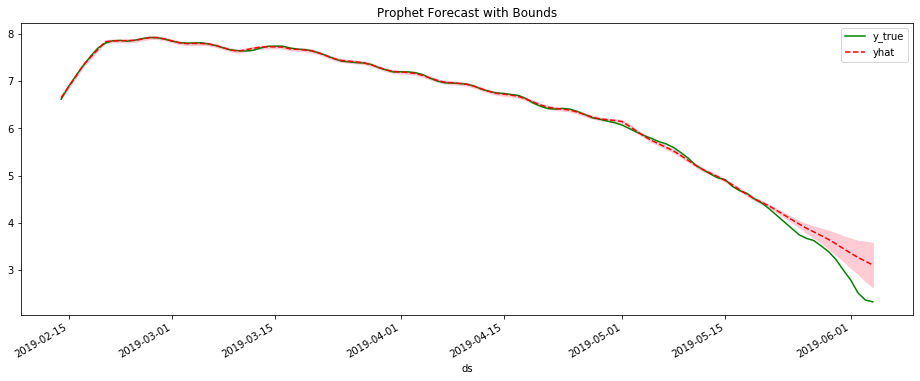

In [127]:
ts_ma1 = ts_moving_avg_train1.copy()
ts_ma1 = ts_ma1.append(ts_moving_avg_test1)
ts_ma1 = ts_ma1.dropna()

true_pred_df = forecast.loc[forecast['ds'].isin(ts_ma1.index)][['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
true_pred_df['y_true'] = ts_ma1.values
print(true_pred_df.shape)

fig, ax = plt.subplots(figsize=(16, 7))
true_pred_df.plot(kind='line', x='ds', y=['y_true', 'yhat'], ax=ax, style=['-','--'], color=['green', 'red'])
ax.fill_between(true_pred_df['ds'].values, true_pred_df['yhat_lower'], true_pred_df['yhat_upper'], alpha=0.8, color='pink')
ax.set(title='Prophet Forecast with Bounds')
fig.autofmt_xdate(bottom=0.3, rotation=30, ha='right')

rmse = sqrt(mean_squared_error(ts_ma1, true_pred_df['yhat'].values))
rmse

#### NOTE

* Prophet can handle NA automatically and forecast smoothly.
* Using logged moving average is also a bit better than logged time series for Sample 1.

### Sample 2

In [161]:
train = pd.DataFrame(ts_moving_avg_train2.copy())
train['ds'] = train.index
train['y'] = ts_moving_avg_train2.values
train.drop(['client_count'], inplace=True, axis=1)
train.head()

,ds,y
purchase_date,,
2019-02-11,2019-02-11,NaN
2019-02-12,2019-02-12,NaN
2019-02-13,2019-02-13,NaN
2019-02-14,2019-02-14,3.572708
2019-02-15,2019-02-15,3.868206


In [163]:
test = pd.DataFrame(ts_moving_avg_test2.copy())
test['ds'] = test.index
test['y'] = ts_moving_avg_test2.values
test.drop(['client_count'], inplace=True, axis=1)
test.head()

,ds,y
purchase_date,,
2019-05-22,2019-05-22,NaN
2019-05-23,2019-05-23,NaN
2019-05-24,2019-05-24,NaN
2019-05-25,2019-05-25,1.170533
2019-05-26,2019-05-26,0.895880


In [164]:
import warnings
warnings.filterwarnings("ignore")

model_ma2 = Prophet(daily_seasonality = True, yearly_seasonality=False, 
                    seasonality_mode = 'multiplicative',
                seasonality_prior_scale=0.1)  # seasonality_prior_scale decides the influence of seasonality
model_ma2.fit(train)

periods = len(test.index) + 2
print(periods)
future = model_ma2.make_future_dataframe(periods=periods)
forecast = model_ma2.predict(future)
print(forecast.shape)

forecast.head()

12
(112, 19)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-02-11,1.643553,3.199572,3.439741,1.643553,1.643553,1.020405,1.020405,1.020405,1.017228,1.017228,1.017228,-0.003178,-0.003178,-0.003178,0.0,0.0,0.0,3.315421
1,2019-02-12,1.728542,3.407554,3.634626,1.728542,1.728542,1.020405,1.020405,1.020405,1.032314,1.032314,1.032314,0.011909,0.011909,0.011909,0.0,0.0,0.0,3.512940
2,2019-02-13,1.813531,3.564577,3.807586,1.813531,1.813531,1.020405,1.020405,1.020405,1.029977,1.029977,1.029977,0.009572,0.009572,0.009572,0.0,0.0,0.0,3.681426
3,2019-02-14,1.898519,3.737187,3.984304,1.898519,1.898519,1.020405,1.020405,1.020405,1.032993,1.032993,1.032993,0.012588,0.012588,0.012588,0.0,0.0,0.0,3.859676
4,2019-02-15,1.983508,3.888155,4.129499,1.983508,1.983508,1.020405,1.020405,1.020405,1.019934,1.019934,1.019934,-0.000471,-0.000471,-0.000471,0.0,0.0,0.0,4.006556


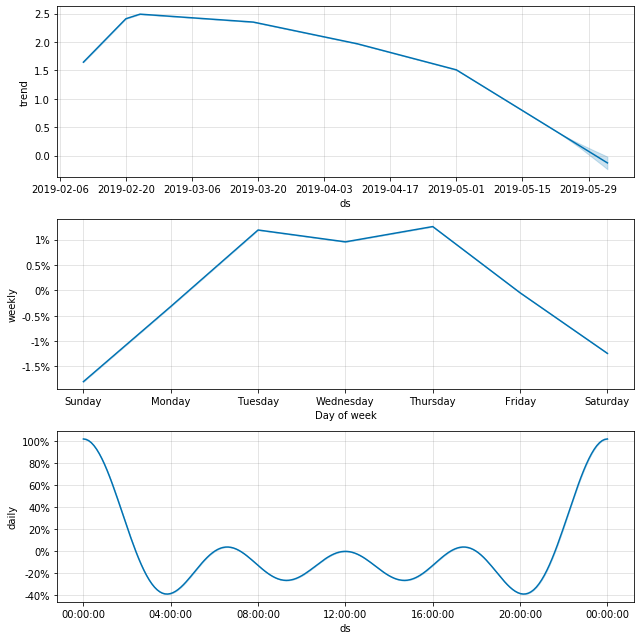

In [166]:
fig1 = model_ma2.plot_components(forecast)

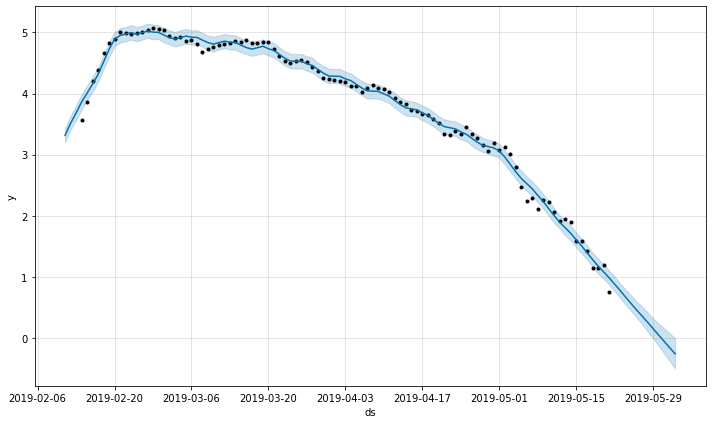

In [167]:
fig2 = model_ma2.plot(forecast)

(7,)


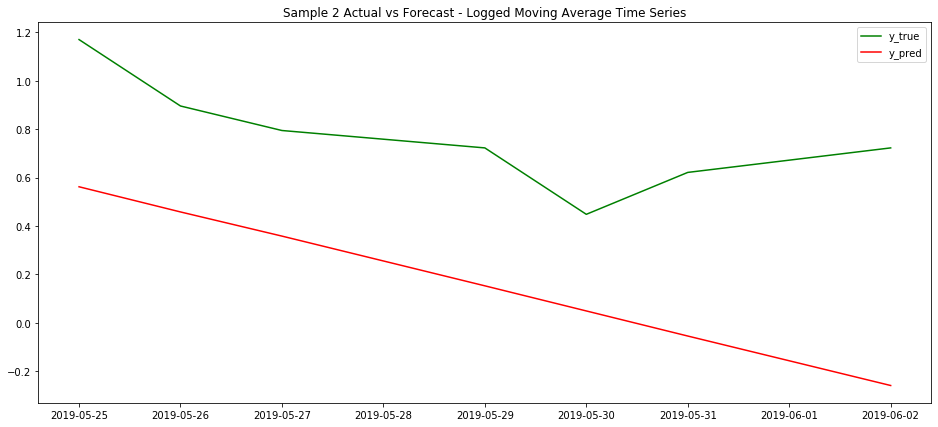

0.6165746114564021

In [169]:
ts_moving_avg_test2 = ts_moving_avg_test2.dropna()

y_pred = forecast.loc[forecast['ds'].isin(ts_moving_avg_test2.index)]['yhat']
y_pred.index = ts_moving_avg_test2.index
print(y_pred.shape)

plt.figure(figsize=(16,7))
plt.plot(ts_moving_avg_test2.index, ts_moving_avg_test2, label='y_true', color='green')
plt.plot(y_pred.index, y_pred, label = 'y_pred', color='red')
plt.legend(loc='best')
plt.title("Sample 2 Actual vs Forecast - Logged Moving Average Time Series")
plt.show()

rmse = sqrt(mean_squared_error(ts_moving_avg_test2, y_pred))
rmse

(104, 5)


0.18330254794307455

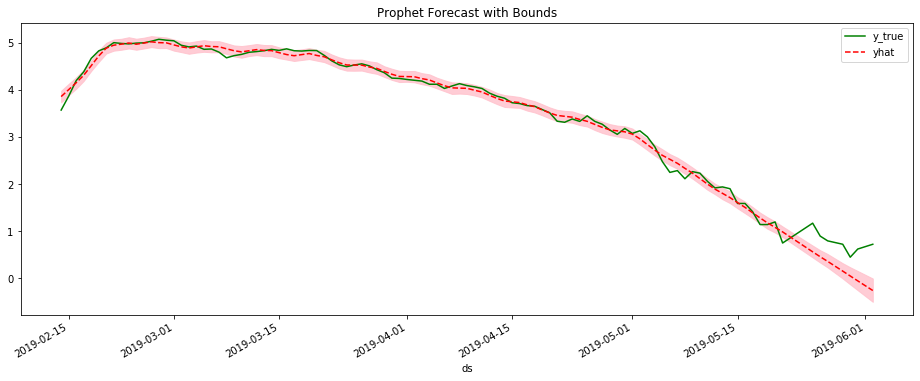

In [171]:
ts_ma2 = ts_moving_avg_train2.copy()
ts_ma2 = ts_ma2.append(ts_moving_avg_test2)
ts_ma2 = ts_ma2.dropna()

true_pred_df = forecast.loc[forecast['ds'].isin(ts_ma2.index)][['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
true_pred_df['y_true'] = ts_ma2.values
print(true_pred_df.shape)

fig, ax = plt.subplots(figsize=(16, 7))
true_pred_df.plot(kind='line', x='ds', y=['y_true', 'yhat'], ax=ax, style=['-','--'], color=['green', 'red'])
ax.fill_between(true_pred_df['ds'].values, true_pred_df['yhat_lower'], true_pred_df['yhat_upper'], alpha=0.8, color='pink')
ax.set(title='Prophet Forecast with Bounds')
fig.autofmt_xdate(bottom=0.3, rotation=30, ha='right')

rmse = sqrt(mean_squared_error(ts_ma2, true_pred_df['yhat'].values))
rmse

#### Note

* Overall, logged moveing average is better than logged data, although forecasting has larger RMSE.

## Summary

* Prophet seems promising, it can handle NA automatically and smoothly. It performace is also better than some moving window solutions for both samples.
* It seems that Prophet is building a function for the whole time series. So next I will try it with moving window solution to see how it goes.
* Logged moving average time series still appears better than logged time series in general.